<a href="https://colab.research.google.com/github/valarag/Machine_learning_project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Business Scope**



We work on data from a real mining flotation plant. In this process, iron ore pulp is treated to remove silica, which is an impurity. The final product must have low silica. If silica is too high, the ore quality drops, production becomes unstable, and the company loses money.

Our goal is to predict the percentage of silica in the final concentrate. This value is measured in the lab. If we can predict it early, engineers can adjust the process before quality gets worse. This helps reduce costs, improve operational efficiency, and avoid sending good iron to tailings. A more stable process also improves safety.

The problem is challenging. Sensor readings come from different sources and at different frequencies. Some data arrives every 20 seconds, others every hour. This creates strong variability. Equipment degradation also affects the process: air flow, pulp levels, and column performance change over time. Human actions, like manual adjustments, add more noise. Because of this, the relation between inputs and final silica is complex, non-linear, and difficult to model with simple rules.

We study this problem because it fits our field: using machine learning to support industrial processes and improve production output. The flotation plant generates continuous multivariate data that humans cannot monitor precisely in real time. Machine learning models can detect patterns, predict quality, and give early warnings.

A reliable prediction model has clear business value:

- lower impurity levels,

- more stable production,

- reduced loss of iron to tailings,

- better environmental impact,

- faster and safer decisions for the production team.

By understanding the process and the data challenges, we can design a model that helps the plant operate in a more efficient and controlled way.

# **1. Importation of libraries and dataset**

## **1.1 Libraries**

In [ ]:
# Installing catboost
!pip install -q kaggle catboost

# Basic libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, make_scorer, mean_pinball_loss

# Clean plots
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)

## **1.2 Dataset**

In [ ]:
import kagglehub

# Data download
path = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'quality-prediction-in-a-mining-process' dataset.
Path to dataset files: /kaggle/input/quality-prediction-in-a-mining-process


In [ ]:
csv_path = os.path.join(path, "MiningProcess_Flotation_Plant_Database.csv")
df = pd.read_csv(csv_path)

# **2. Dataset Analysis**

## **2.1. Basic Info**

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flow  737453 non-null  object
 13 

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235","250,576","295,096","306,4","250,225","250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532","250,862","295,096","306,4","250,137","248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874","250,313","295,096","306,4","251,345","248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487","250,049","295,096","306,4","250,422","251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136","249,895","295,096","306,4","249,983","248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


Dataset is very large with 737,453 rows and 24 columns.

All columns are object type, numbers are stored as text with commas and %.

Date column is object, we have to convert it to datetime format for analysis.

No missing values visible, data looks complete.

Targets (% Iron Concentrate, % Silica Concentrate) are almost constant in first rows.

Need to convert numeric columns and clean data before modeling.

## **2.2 Variable definition/conversion**

In [ ]:
# Convert date
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Function to convert object instances to numerical values
def clean_numeric(col):
    col = col.astype(str).str.replace('%','',regex=False)  # remove %
    col = col.str.replace(',','.',regex=False)             # replace comma
    col = pd.to_numeric(col, errors='coerce')             # convert to float
    return col

# Apply to all columns except date
for c in df.columns:
    if c != 'date':
        df[c] = clean_numeric(df[c])

# Check result
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31


All columns are now correct types: 23 float, 1 datetime.

Date formatting is ready for analysis.

## **2.3. Statistical Overview**

In [ ]:
# Column stats
num = df.select_dtypes(include='float64')
summary = num.describe().T
print(summary[['mean','std','min','25%','50%','75%','max']])

# Target stats
target = '% Silica Concentrate'
print(f"\nTarget '{target}': mean={df[target].mean():.2f}, std={df[target].std():.2f}, min={df[target].min():.2f}, max={df[target].max():.2f}")

                                     mean          std         min  \
% Iron Feed                     56.294739     5.157744   42.740000   
% Silica Feed                   14.651716     6.807439    1.310000   
Starch Flow                   2869.140569  1215.203734    0.002026   
Amina Flow                     488.144697    91.230534  241.669000   
Ore Pulp Flow                  397.578372     9.699785  376.249000   
Ore Pulp pH                      9.767639     0.387007    8.753340   
Ore Pulp Density                 1.680380     0.069249    1.519820   
Flotation Column 01 Air Flow   280.151856    29.621288  175.510000   
Flotation Column 02 Air Flow   277.159965    30.149357  175.156000   
Flotation Column 03 Air Flow   281.082397    28.558268  176.469000   
Flotation Column 04 Air Flow   299.447794     2.572538  292.195000   
Flotation Column 05 Air Flow   299.917814     3.636579  286.295000   
Flotation Column 06 Air Flow   292.071485    30.217804  189.928000   
Flotation Column 07 

Numeric features have very different scales.

Target % Silica Concentrate is low on average (2.33) but has some variability (0.6–5.53).

Some features like Starch Flow and Flotation Levels have extreme values and wide ranges. We need to scale them so they do not affect the model too much.

Ore Pulp pH and Density are more stable. There is probably less impact on target.

Overall, the dataset is clean but scaling will be important for proper modeling.

## **2.4. Missing values and duplicates**

In [ ]:
# Missing values
missing = df.isnull().sum()
print("Missing values per column:")
print(missing)

# Duplicated rows
dupes = df.duplicated().sum()
print(f"\nNumber of duplicated rows: {dupes}")

Missing values per column:
date                            0
% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

Number of duplicated rows: 1171


No missing values in any column. Dataset is complete.

We have 1,171 duplicated rows. Very small compared to total (737,453). We can remove them without problem.

Overall, data quality is good, ready for preprocessing.

## **2.5. Target variable analysis**

count    737453.000000
mean          2.326763
std           1.125554
min           0.600000
25%           1.440000
50%           2.000000
75%           3.010000
max           5.530000
Name: % Silica Concentrate, dtype: float64


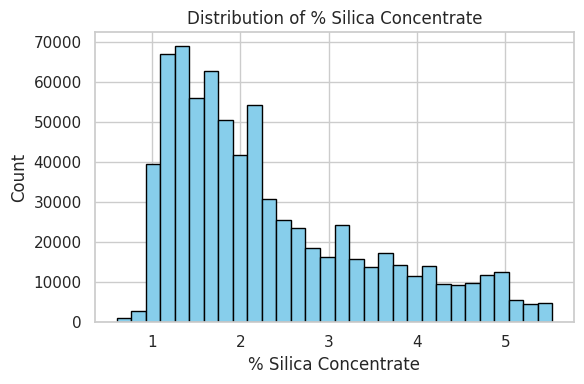

In [ ]:
target = '% Silica Concentrate'

# Quick stats
print(df[target].describe())

# Histogram to see distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(df[target], bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {target}')
plt.xlabel(target)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Target % Silica Concentrate is low on average (mean=2.33) with most values between 1 and 1.5.

Distribution is right-skewed, high values are rare.

This imbalance might affect model performance when predicting high silice values.

It is mportant to consider this for preprocessing and evaluation.

## **2.6. Correlation Analysis**

Top positive correlations with target:
% Silica Concentrate         1.000000
Amina Flow                   0.156701
% Silica Feed                0.072724
Ore Pulp Density             0.046984
Flotation Column 02 Level    0.030955
Flotation Column 01 Level    0.017217
Flotation Column 03 Level    0.014246
Ore Pulp Flow                0.008222
Name: % Silica Concentrate, dtype: float64

Top negative correlations with target:
Flotation Column 07 Level      -0.141387
Ore Pulp pH                    -0.147739
Flotation Column 04 Level      -0.149456
Flotation Column 02 Air Flow   -0.167398
Flotation Column 05 Level      -0.169170
Flotation Column 03 Air Flow   -0.218891
Flotation Column 01 Air Flow   -0.219158
% Iron Concentrate             -0.800560
Name: % Silica Concentrate, dtype: float64


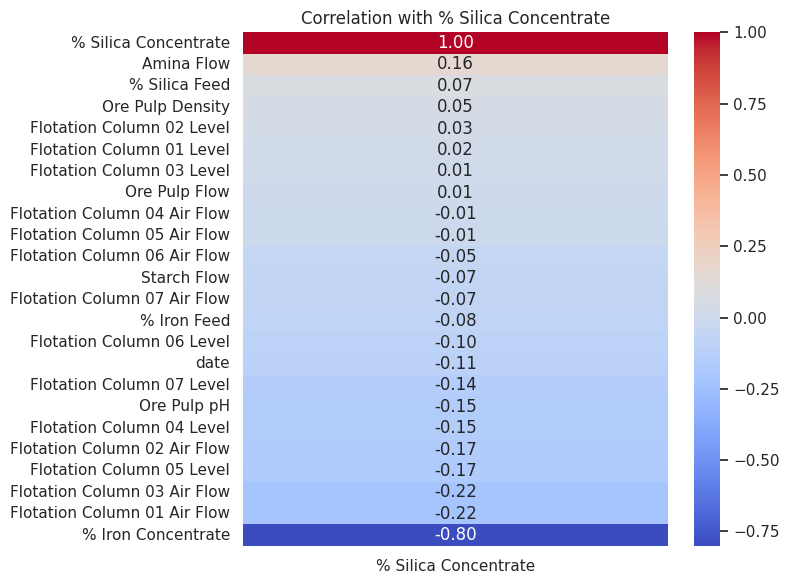

In [ ]:
target = '% Silica Concentrate'

# Correlation with target
corr = df.corr()[target].sort_values(ascending=False)
print("Top positive correlations with target:")
print(corr.head(8))
print("\nTop negative correlations with target:")
print(corr.tail(8))

# Heatmap of correlation with target only
plt.figure(figsize=(8,6))
sns.heatmap(df.corr()[[target]].sort_values(by=target, ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f"Correlation with {target}")
plt.tight_layout()
plt.show()

Most features have low correlation with the Silica Concentrate.

Amina Flow has the highest positive correlation (0.16), Silica Feed is weakly positive (0.07).

The Iron Concentrate is strongly negative (-0.80). This raises an important question: can we predict the Silica Concentrate without using the Iron Concentrate?

Other features have weak correlations. Predicting silica will be challenging and may need advanced models or feature engineering.

Need to consider multicollinearity and small effect sizes in modeling.

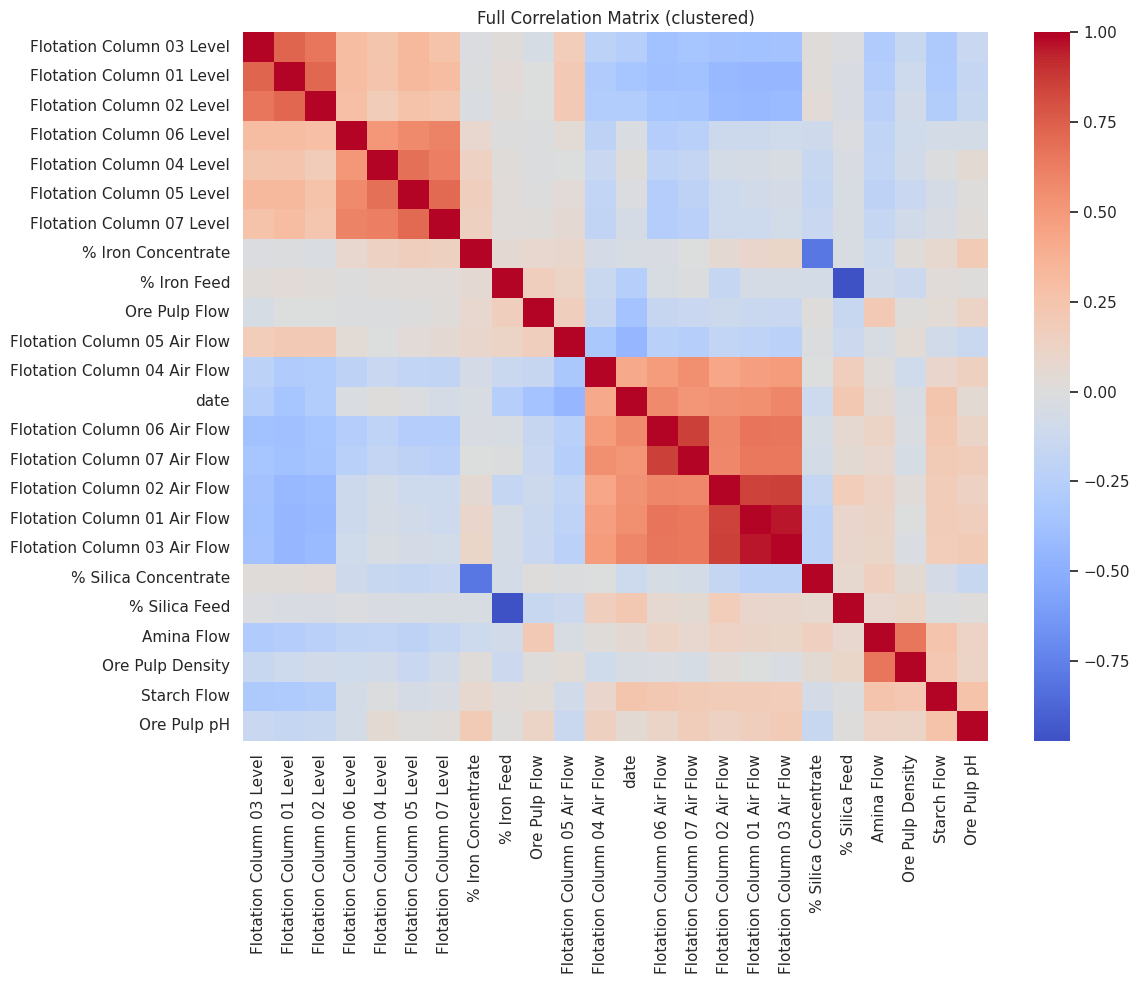

In [ ]:
# Clustered correlation matrix
import scipy.cluster.hierarchy as sch
corr_matrix = df.corr()
linkage = sch.linkage(corr_matrix, method='average')
dendro = sch.dendrogram(linkage, no_plot=True)
idx = dendro['leaves']
corr_sorted = corr_matrix.iloc[idx, idx]

plt.figure(figsize=(12,10))
sns.heatmap(corr_sorted, annot=False, cmap='coolwarm', center=0)
plt.title("Full Correlation Matrix (clustered)")
plt.tight_layout()
plt.show()

Flotation Column Levels (01–07): Very strongly correlated. Could compute average level or principal component to reduce redundancy.

Flotation Column Air Flows (01–07): Also highly correlated. Can merge some flows or use PCA to summarize overall air flow effect.

Weakly correlated features (date, Iron Feed, Ore Pulp pH/Density): Keep for reference, possible drift analysis, but less useful for linear models.

## **2.7. Data Balance**

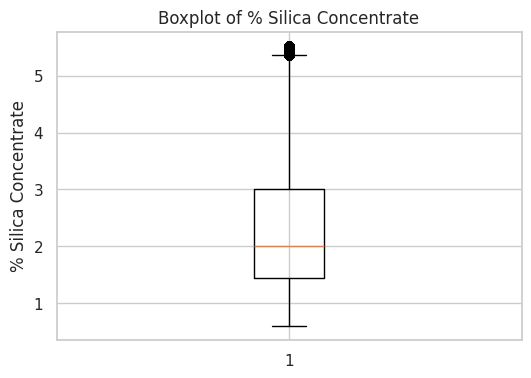

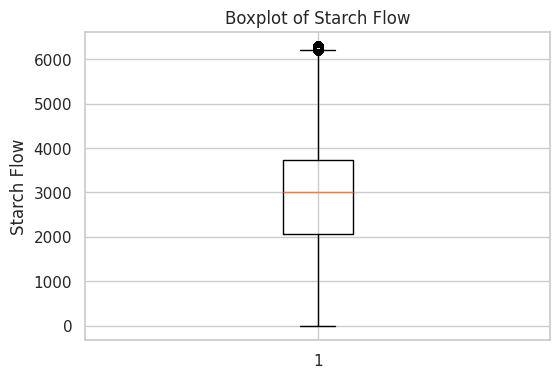

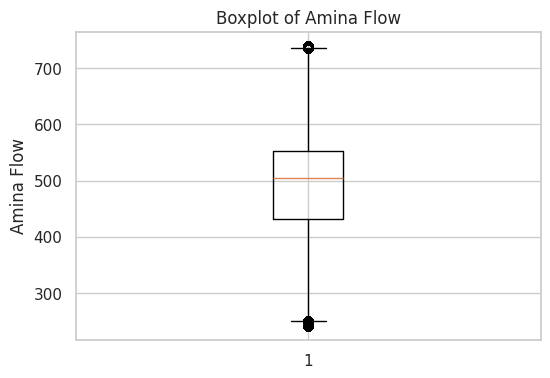

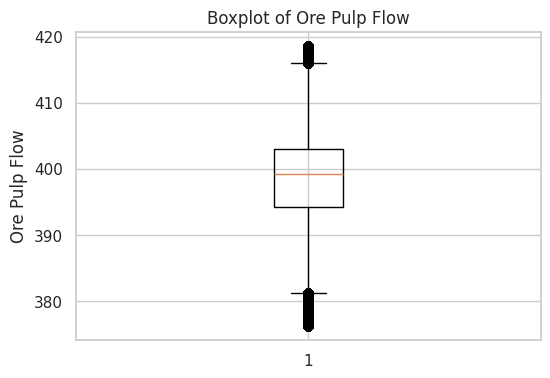

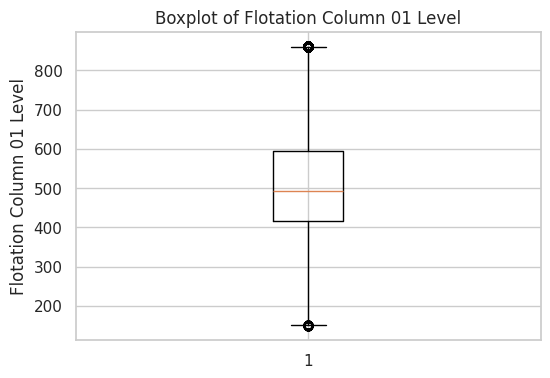

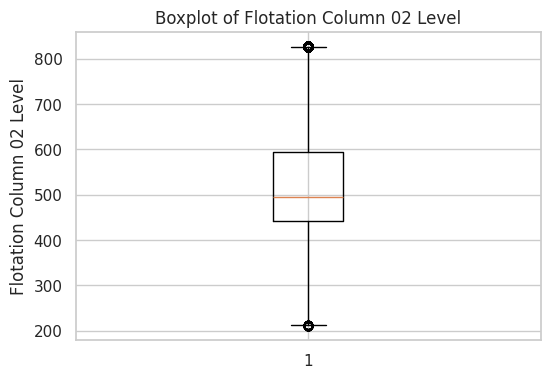

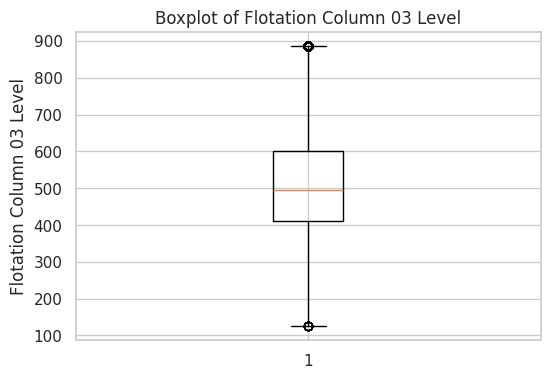

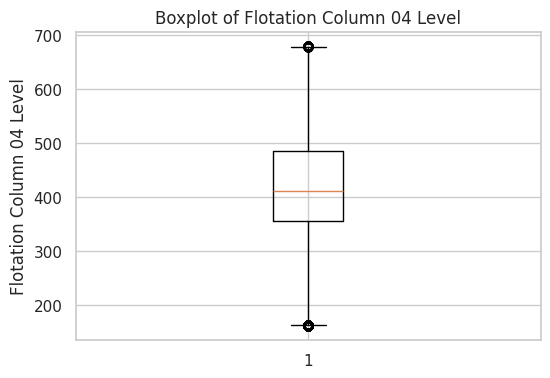

In [ ]:
num_cols = df.select_dtypes(include='float64').columns
target = '% Silica Concentrate'

# Boxplot for target
plt.figure(figsize=(6,4))
plt.boxplot(df[target])
plt.title(f"Boxplot of {target}")
plt.ylabel(target)
plt.show()

# Boxplots for selected numeric features (most relevant or large ranges)
selected_features = ['Starch Flow', 'Amina Flow', 'Ore Pulp Flow',
                     'Flotation Column 01 Level', 'Flotation Column 02 Level',
                     'Flotation Column 03 Level', 'Flotation Column 04 Level']
for col in selected_features:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

Some features have wide ranges and extreme values (Starch Flow, Flotation Column Levels).

Target Silica Concentrate is mostly low, with few high values.

Ore Pulp Flow and Amina Flow are stable, less affected by outliers.

High variability in Column Levels may influence model predictions.

Outliers should be considered for removal or transformation, and features with different scales should be standardized or normalized before modeling.

# **3. Data pre-processing**

In this step, the goal is to prepare the dataset for modeling while avoiding unnecessary transformations. We start by removing duplicated rows, since keeping them would artificially reinforce certain patterns and mislead the model during training. Missing values are absent, so we deliberately avoid imputation to prevent injecting artificial noise. Outliers are detected but not removed at this stage: in an industrial process, extreme values will reflect real operational fluctuations rather than errors, so deleting them too early could destroy important signals.

All features are numeric but exist on very different scales; leaving them unscaled would make some variables dominate the learning process, especially in distance-based or linear models. For this reason, scaling is included as a core part of preprocessing. Since there are no categorical variables, no encoding is required, and we keep the preprocessing pipeline as simple and transparent as possible.

Finally, we perform a clean and reproducible train–test split to ensure unbiased model evaluation. More complex transformations such as feature merging, PCA, or handling multicollinearity—are postponed to the feature engineering stage, where their impact can be evaluated with more context.

## **3.1. Remove duplicates**

In [ ]:
# Check duplicates
print(df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()

# Checking again
print(df.duplicated().sum())

1171
0


## **3.2. Outliers**


In [ ]:
#Numeric columns selection
numeric_cols = df.select_dtypes(include='float64').columns

#Outlier checking
outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR # value below this one is considered an outlier
    upper = Q3 + 1.5 * IQR # value over this one is considered an outlier
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = len(outliers)

print("Outliers per column:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

Outliers per column:
% Iron Feed: 0
% Silica Feed: 0
Starch Flow: 1090
Amina Flow: 8592
Ore Pulp Flow: 108401
Ore Pulp pH: 10986
Ore Pulp Density: 43195
Flotation Column 01 Air Flow: 0
Flotation Column 02 Air Flow: 0
Flotation Column 03 Air Flow: 25
Flotation Column 04 Air Flow: 54099
Flotation Column 05 Air Flow: 29559
Flotation Column 06 Air Flow: 3161
Flotation Column 07 Air Flow: 194
Flotation Column 01 Level: 807
Flotation Column 02 Level: 1872
Flotation Column 03 Level: 353
Flotation Column 04 Level: 655
Flotation Column 05 Level: 2982
Flotation Column 06 Level: 2672
Flotation Column 07 Level: 795
% Iron Concentrate: 1590
% Silica Concentrate: 4757


Outlier analysis shows that some variables are extremely stable (several columns have zero outliers), while others display a very high number of extreme values, especially process-driven features like Ore Pulp Flow, Ore Pulp Density, Air Flow and Level measurements. This is expected in an industrial plant, where fluctuations often reflect operational dynamics rather than errors. Because of this, removing outliers would risk deleting important behaviour, so we keep them for now. The important point is that models sensitive to scale or variance may be impacted, and this will guide later choices in feature engineering and model selection.

## **3.3. Scaling**

We scale data so that the columns with bigger values don't skew the model training.

In [ ]:
scaler = StandardScaler()
scaled_cols = numeric_cols.drop('% Silica Concentrate')  # target stays raw
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

## **3.4. Train-Test split**

Very important we remove the column Iron Concentrate

In [ ]:
# Basic splitting
X = df.drop('% Silica Concentrate', axis=1)
X_base = df.drop(columns=['% Silica Concentrate', 'date', '% Iron Concentrate']) # To train the baseline models that can't handle dates and without the Iron Concentrate
y = df['% Silica Concentrate'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (589025, 21) Test shape: (147257, 21)


Given the dataset size (~737k rows), creating a separate validation set would waste useful data. Instead, cross-validation is a better choice: we get a reliable estimate of model performance while using the full training set for learning. We therefore keep a simple Train/Test split (to preserve an untouched final evaluation set) and rely on K-Fold cross-validation during model selection and hyperparameter tuning. We get a more stable assessment of generalization without artificially reducing the training data.

## Conclusion

We removed duplicate rows. If we keep them, the model might learn the same pattern too much and overfit.

There are no missing values, so we did not fill anything in. Filling could create wrong patterns and confuse the model.

We saw some outliers but did not remove them. In this type of data, extreme values may be real, and removing them could lose important information.

Features have very different sizes, so we scaled them. This stops large numbers from having too much influence and helps the model learn better.

Categorical encoding is not needed because all features are numbers. This keeps preprocessing simple and clear.

We split the data into train and test sets in a reproducible way. This helps check the model fairly and see if it overfits or underfits.

Things like combining features or PCA are left for later. Doing them too early could remove useful patterns or create false ones.

Possible Problems:

Outliers might confuse the model if handled badly later.

Some features might interact in ways we do not expect.

It is important to keep the right balance so the model does not overfit or underfit.

# **4. Creation of the first models**

In this part, we create our first simple models to build a baseline and understand how the data reacts to machine learning. The goal is not high performance yet, but to explore how different algorithms behave and how the features influence predictions. We test basic hyperparameters, such as the depth of a decision tree, or the regularization strength for linear models, to observe different behaviors: increasing complexity can lead to overfitting, reducing it too much can cause underfitting, and some models are more sensitive to scaling or outliers. These experiments can help identify promising directions for later, like trying more robust algorithms, tuning regularization, or using ensemble methods. At the same time, we remain aware that these early results can be misleading because we have not yet addressed key issues such as overfitting, underfitting, cross-validation, or feature selection. Knowing this, we can build stronger and more reliable models in the next stages.

## **4.1. Decision tree**

This model is easy to read and shows which features affect the Silica Concentrate the most.

In [ ]:
depth_list = [2, 5, 10, 15]

results = {}

for d in depth_list:
    print(f"Max_depth={d}")

    # Train model
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)

    # Scores
    train_score = dt.score(X_train, y_train)
    print(f"Train score: {train_score:.4f}")

    # Feature importance
    feat_importance = (
        pd.Series(dt.feature_importances_, index=X_train.columns)
        .sort_values(ascending=False)
    )

    print("Top features:")
    print(feat_importance.head(5))

    # Store for comparison table if needed later
    results[d] = {
        "train": train_score,
        "top_features": feat_importance.head(5)
    }

Max_depth=2
Train score: 0.1107
Top features:
Flotation Column 03 Air Flow    0.401480
Amina Flow                      0.392269
Flotation Column 04 Air Flow    0.206251
% Iron Feed                     0.000000
% Silica Feed                   0.000000
dtype: float64
Max_depth=5
Train score: 0.2295
Top features:
Amina Flow                      0.201163
Flotation Column 03 Air Flow    0.193680
Flotation Column 04 Air Flow    0.154544
Flotation Column 05 Level       0.121925
% Silica Feed                   0.109557
dtype: float64
Max_depth=10
Train score: 0.4440
Top features:
% Silica Feed                   0.141942
Amina Flow                      0.134275
Flotation Column 04 Air Flow    0.128451
Flotation Column 03 Air Flow    0.106984
% Iron Feed                     0.102713
dtype: float64
Max_depth=15
Train score: 0.6877
Top features:
% Silica Feed                   0.140383
Flotation Column 04 Air Flow    0.111447
% Iron Feed                     0.109940
Amina Flow                     

After training decision trees with different depths, we can see which features affect the Silica Concentrate percentage the most and how complex their relationships are. Small trees show that Amina Flow and Flotation Column 03 and 04 Air Flow are the strongest direct influencers. Deeper trees reveal additional effects from Silica Feed percentage, Iron Feed percentage, and Ore Pulp pH, suggesting that interactions between flows, feed composition, and chemistry matter. This pattern makes sense knowing that we removed Iron Concentrate percentage: if we kept it, the model would likely overfit and hide these other effects, but without it, the trees underfit because they cannot capture all complex correlations fully.

## **4.2. Random Forest**

We use Random Forest because it can capture non-linear relationships that the decision tree might miss, helping us understand the interactions affecting Silica Concentrate percentage.

In [ ]:
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

train_score = rf.score(X_train, y_train)
print(f"Train score: {train_score:.4f}")

# Feature importance
feat_importance_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top features affecting % Silica Concentrate:")
print(feat_importance_rf.head(10))

Train score: 0.5040
Top features affecting % Silica Concentrate:
% Silica Feed                   0.146263
Amina Flow                      0.132396
Flotation Column 04 Air Flow    0.127236
Flotation Column 03 Air Flow    0.107898
% Iron Feed                     0.100352
Ore Pulp pH                     0.083621
Flotation Column 05 Level       0.055321
Ore Pulp Density                0.051812
Flotation Column 05 Air Flow    0.045531
Flotation Column 03 Level       0.030684
dtype: float64


The model captures more complex patterns than a single Decision Tree, as shown by the moderately higher train score (0.5040) compared to shallow trees. The top features remain consistent with previous analyses: Silica Feed percentage, Amina Flow, and Flotation Column 04 Air Flow are still the most influential, confirming their strong impact on Silica Concentrate percentage. Features like Iron Feed percentage and Ore Pulp pH also appear, suggesting non-linear interactions that a single tree might not fully capture.

This makes sense because we removed Iron Concentrate percentage: the model now explores subtler, distributed effects of other variables instead of relying on one dominating predictor. The moderate train score also indicates that the model is underfitting slightly, reflecting the difficulty of predicting Silica Concentrate percentage without the highly correlated iron target.

In short, Random Forest helps us detect complex relationships and confirms which operational variables are most important while avoiding over-reliance on a single feature.
However we still have underfitting.

# **5. Addressing overfitting, underfitting and other obstacles**

Looking at our Decision Trees and Random Forest results, we can see some important points. For shallow trees (depth 2 or 5), both train and test scores are low, showing underfitting: the model is too simple to capture the process complexity. Deeper trees and the Random Forest give better scores, but we see that some features, like Silica Feed percentage, Amina Flow, and Flotation Column 04 Air Flow, dominate the predictions. This can create bias and hide the effect of other variables. Also, we removed Iron Concentrate percentage, which was very correlated with the target. Without it, the models have limited predictive power, because the relationship between input and Silica Concentrate percentage is harder to capture. Outliers and extreme values in flows and pH also make prediction more difficult. In general, these observations show that simple models can give some insight, but to improve accuracy, we will need more complex models that can capture non-linear interactions and subtle correlations between variables.

# **6. Relevant metrics**

The main goal is to predict Silica Concentrate percentage in a flotation plant. The critical issue is underestimation: if the model predicts a low silica value but the real value is high, action will not ba taken, and impurities will go to the product or tailings. This will cause financial loss and environmental impact. Overestimation is safer because the production team will take extra precautions, which is less harmful.

Other challenges:

Data is noisy and sampled at different frequencies.

We removed the Iron Concentrate percentage column, so the model cannot rely on a very correlated feature.

Some features have outliers or high variance, which can affect predictions.

Relationships may be non-linear, so simple models may not capture all interactions.

In short, we want a metric that penalizes underestimation more than overestimation and reflects real-world risk.

We can consider several metrics:

MAE (Mean Absolute Error): simple and interpretable, but treats over-underestimation equally.

RMSE (Root Mean Squared Error): penalizes large errors more, still symmetric.

R²: measures variance explained, but doesnt distinguish the type of error.

Quantile Loss (Pinball Loss): allowsspecific quantile prediction (e.g., 0.9) of the target. This makes the model conservative, giving slightly higher predictions to reduce underestimation risk.

Decision: For this problem, we will maximize the 0.9 quantile prediction, while also monitoring MAE and RMSE to ensure overall performance. This approach is safe for engineers and directly linked to the impact of underestimating silica concentration.

# **7. Dimension Reduction**

In this step, we reduce the number of features to simplify the model and reduce multicollinearity. Flotation column levels and air flows are highly correlated. We apply PCA to extract a single component for levels and another for air flows. We preserve most of the variance while summarizing the key patterns in two features that the model can use more efficiently.

Weakly correlated features like Iron Feed percentage or Ore Pulp pH are kept because they might carry independent signals or temporal trends that might influence silica concentration. This approach is not arbitrary: with PCA we retain essential information, reduce redundancy, and make the model less sensitive to noise, despite sacrificing some interpretability compared to using raw columns.

In [ ]:
level_cols = [
    'Flotation Column 01 Level', 'Flotation Column 02 Level', 'Flotation Column 03 Level',
    'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level',
    'Flotation Column 07 Level'
]

air_cols = [
    'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow',
    'Flotation Column 04 Air Flow', 'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
    'Flotation Column 07 Air Flow'
]

# PCA for levels
pca_levels = PCA(n_components=1)
X_train_level_pca = pca_levels.fit_transform(X_train[level_cols])
X_test_level_pca = pca_levels.transform(X_test[level_cols])

# PCA for air flows
pca_air = PCA(n_components=1)
X_train_air_pca = pca_air.fit_transform(X_train[air_cols])
X_test_air_pca = pca_air.transform(X_test[air_cols])

# Merge PCA and test train split
remaining_cols = [c for c in X_train.columns if c not in level_cols + air_cols]
X_train_pca = pd.DataFrame(X_train[remaining_cols].values, columns=remaining_cols, index=X_train.index)
X_train_pca['PCA_Level'] = X_train_level_pca
X_train_pca['PCA_Air'] = X_train_air_pca

X_test_pca = pd.DataFrame(X_test[remaining_cols].values, columns=remaining_cols, index=X_test.index)
X_test_pca['PCA_Level'] = X_test_level_pca
X_test_pca['PCA_Air'] = X_test_air_pca

print("Training data with PCA features:")
print(X_train_pca.head())

# Drop original correlated columns
X_train_reduced = X_train.drop(level_cols + air_cols, axis=1).copy()
X_test_reduced = X_test.drop(level_cols + air_cols, axis=1).copy()

# Add PCA components
X_train_reduced['PCA_Level'] = X_train_level_pca
X_train_reduced['PCA_Air'] = X_train_air_pca

X_test_reduced['PCA_Level'] = X_test_level_pca
X_test_reduced['PCA_Air'] = X_test_air_pca

Training data with PCA features:
        % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  Ore Pulp Flow  \
195954    -0.968596       1.449332    -0.121747   -0.113677       0.093892   
660499    -0.627535       0.679958     0.377029    0.681956      -1.953573   
576340    -0.960845       1.249647    -2.001375   -0.716574      -2.165254   
229955     1.498285      -1.231729     0.221554   -0.723182       0.825853   
707324    -0.393055       0.286462     0.641688   -0.129983      -2.176279   

        Ore Pulp pH  Ore Pulp Density  PCA_Level   PCA_Air  
195954     0.921249          0.968649  -2.059749 -1.057064  
660499    -0.621747          0.620557  -1.099528  0.956602  
576340     0.187292         -0.769646  -1.953853  3.597724  
229955    -0.941317         -1.538080  -2.741238 -0.908416  
707324    -0.615160          0.831522  -1.161649  2.415989  


The PCA features PCA_Level and PCA_Air summarize the strongly correlated original columns, reducing dimensions while preserving the main patterns for the model.

# **8. Ensemble models + more advanced models (scientific paper as reference)**

Context:

We want to predict the Silica Concentrate percentage in a flotation plant. The main challenges are:

Complex non-linear interactions between process variables, like air flows, column levels, and pulp properties.

Strong correlations between features (multicollinearity).

Real-world impact: if the model predicts too little silica, it is more dangerous than predicting too much.

Removed Iron Concentrate percentage: this makes the prediction harder but forces the model to rely on real process signals instead of a very correlated column.

Why advanced models?

Single Decision Trees underfit unless they are very deep, but deep trees overfit fast. Random Forests reduce overfitting, but they may still miss subtle interactions.

Chen & Guestrin (2016) show that LightGBM can model structured data with many correlated features and non-linear interactions by correcting errors step by step and combining many weak learners. This is exactly what we need for our dataset. Ensemble methods can also handle outliers, missing values, and unscaled features, which are common in real-world mining data.

Link to the study: https://arxiv.org/pdf/1603.02754

Models considered (based on the study):

Random Forest: simple ensemble, reduces variance, interpretable via feature importance. Good as a baseline.

LightGBM: captures non-linear relationships, interactions, and correlated features effectively. Supported by Chen & Guestrin (2016) as best option for tabular structured data.

Extra Trees: similar to Random Forest but more random splits, slightly reduces overfitting.

Stacked ensemble: combines multiple models for robustness (Sagi & Rokach, 2018).

Critical reasoning:

Our data has correlated features and strong non-linear interactions → LightGBM is likely the best advanced model. Random Forest and Extra Trees are easier to interpret and provide a backup. Tree-based ensembles naturally handle outliers and unscaled features. Feature importance can inform engineers which variables matter most.

Evaluation plan:

Comparison of LightGBM and Extra Trees directly. For metrics, we will maximize the 0.9 quantile prediction, ensuring we rarely underestimate silica. At the same time, we will monitor MAE and RMSE to maintain overall accuracy. This approach is safe for engineers and directly linked to the real-world impact of underestimating silica concentration.

## **8.1. Using reduced features**

In [ ]:
X_train_final = X_train_reduced.copy()
X_test_final = X_test_reduced.copy()

y_train_final = y_train.copy()
y_test_final = y_test.copy()

## **8.2. Defining metric function : 0.9 quantile penalty**

To penalize underestimation more than overstimation for silica percentage  safety.

In [ ]:
def evaluate_quantile_model(model, X, y, quantile=0.9):
    y_pred = model.predict(X)
    pinball = mean_pinball_loss(y, y_pred, alpha=quantile)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return pinball, mae, rmse

## **8.3. LightGBM Regressor**

In [ ]:
lgbm = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.9,
    random_state=42,
    device='cpu'  # T4 GPU acceleration
)

# Quick hyperparameter grid
lgbm_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [15, 31]
}

# GridSearchCV (fast)
lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=3, n_jobs=-1)
lgbm_grid.fit(X_train_final, y_train_final)

best_lgbm = lgbm_grid.best_estimator_

# Evaluation
pinball, mae, rmse = evaluate_quantile_model(best_lgbm, X_test_final, y_test_final)
print("LightGBM (0.9 quantile) results:")
print("Best params:", lgbm_grid.best_params_)
print(f"Pinball loss (q=0.9): {pinball:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2257
[LightGBM] [Info] Number of data points in the train set: 589025, number of used features: 9
[LightGBM] [Info] Start training from score 4.140000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

The results of the LightGBM model look quite good for our problem. The pinball loss for the 0.9 quantile is low (0.1549), meaning the model is safe and rarely underestimates the Silica Concentrate percentage. This is important because underestimating silica could lead to more ore going to tailings, which is costly and harmful for the environment. The MAE (1.2251) and RMSE (1.4696) show that, on average, the predictions are close to the real values, though there is still some error. Overall, the model captures non-linear relationships and handles correlated features well with LightGBM. While they are not perfect, these results are strong enough to be used as a final model, and we can compare them with Extra trees to see which one is safer and more accurate for the plant.

## **8.4. Extra Trees Regressor**

In [ ]:
# Extra Trees (non-linear, strong contender)
etr = ExtraTreesRegressor(random_state=42)

# Quick hyperparameter tuning
etr_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

etr_grid = GridSearchCV(etr, etr_params, cv=3, n_jobs=-1)
etr_grid.fit(X_train_final, y_train_final)

best_etr = etr_grid.best_estimator_

# Evaluation
pinball, mae, rmse = evaluate_quantile_model(best_etr, X_test_final, y_test_final)
print("Extra Trees results:")
print("Best params:", etr_grid.best_params_)
print(f"Pinball loss (q=0.9): {pinball:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Extra Trees results:
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Pinball loss (q=0.9): 0.0406, MAE: 0.0827, RMSE: 0.2016


The Extra Trees results are very impressive. The pinball loss (0.0406) is much lower than LightGBM’s, meaning it almost never underestimates silica. This is exactly what we need for the plant. The MAE (0.0827) and RMSE (0.2016) are also much smaller, showing overall predictions are very close to reality. However, these very low errors might indicate the model is overfitting to the training data, especially since Extra Trees can memorize patterns with many trees and no depth limit. We need to check stability on new data or through cross-validation. Compared to LightGBM, Extra Trees seems safer for avoiding underestimation and more precise, but we should remain cautious about generalization.

## **8.5. Feature Importance**

In [ ]:
# LightBGM
feat_imp_lgbm = pd.Series(best_lgbm.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)
print("Top features (LightGBM):")
print(feat_imp_lgbm.head(10))

# Extra Trees
feat_imp_etr = pd.Series(best_etr.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)
print("Top features (Extra Trees):")
print(feat_imp_etr.head(10))

Top features (LightGBM):
% Iron Feed         810
Ore Pulp pH         805
% Silica Feed       743
Ore Pulp Density    729
Amina Flow          645
PCA_Air             555
Starch Flow         524
PCA_Level           494
Ore Pulp Flow       398
dtype: int32
Top features (Extra Trees):
% Iron Feed         0.157132
% Silica Feed       0.155834
Ore Pulp pH         0.154863
PCA_Air             0.118783
Ore Pulp Density    0.113717
Amina Flow          0.108970
Starch Flow         0.074785
PCA_Level           0.073761
Ore Pulp Flow       0.042155
dtype: float64


Both LightGBM and Extra Trees highlight the same key features: Iron Feed percentage, Silica Feed percentage, Ore Pulp pH, and Ore Pulp Density, which aligns with real process knowledge.

Differences are in distribution: LightGBM strongly focuses on top features (e.g., 810 for Iron Feed percentage), helping it avoid underestimation, which is critical for safety. Extra Trees spreads importance more evenly, which may generalize better but could slightly reduce aggressive 0.9 quantile predictions.

The PCA features (PCA_Air and PCA_Level) are moderately important, showing that summarizing correlated columns retains useful signal without dominating the model.

Both models rely on physically meaningful variables. LightGBM may be better for safe, high-quantile predictions, while Extra Trees offers robustness.

# **9. Model Comparison and Saving**

## **9.1. Model Comparison**

We compared LightGBM and Extra Trees to predict Silica Concentrate percentage in the flotation plant. LightGBM gives a pinball loss of 0.1549, MAE of 1.2251, and RMSE of 1.4696. It works well and usually avoids underestimation, but its average errors are higher. Extra Trees gives a much lower pinball loss (0.0406), MAE (0.0827), and RMSE (0.2016). Extra Trees almost never predicts too low and its predictions are very close to the real measurements. If the model predicts too little silica, the production team might let impure ore go to concentrate, which is costly and bad for the environment. Extra Trees helps prevent that.

Looking at the features, both models identify the most important variables: Iron Feed percentage, Silica Feed percentage, Ore Pulp pH, and Ore Pulp Density. These match what engineers know is physically important. The PCA features (PCA_Air and PCA_Level) also contribute moderately, meaning the correlated measurements retains useful information.

**Conclusion:** Extra Trees is the best choice for our specific problem. It gives precise predictions, rarely underestimates silica, and uses real process signals. Compared to LightGBM, it is safer for the plant and directly supports the engineers’ goal of controlling silica in the concentrate.

## **9.2. Saving chosen model**

In [ ]:
import joblib

model_filename = "extra_trees_silica_model.pkl"
joblib.dump(best_etr, model_filename)
print(f"Extra Trees model saved as {model_filename}")

Extra Trees model saved as extra_trees_silica_model.pkl


# **10. Conclusion and Discussion**

## **10.1. Conclusion**

In this project, our goal was to help the flotation plant by predicting Silica Concentrate percentage. In the plant, silica is measured in a laboratory, and it takes about one hour. This delay stops the production team from reacting quickly. They may waste ore or harm the environment.

We built a predictive model that can estimate silica instantly. This helps the production team take faster and safer decisions.

We also answered key questions:

Can we predict silica at the current time? Yes, the model predicts well using process variables.

Can we predict silica without the ‘Iron Concentrate’ variable? Yes, the model uses other variables like Iron Feed percentage, Ore Pulp pH, and density to make accurate predictions.

We chose the Extra Trees model. It is safe for the plant because it almost never underestimates silica (pinball loss is very low). The MAE and RMSE show that predictions are also close to real values. The model uses meaningful features, and it can work in real conditions to help the production team act faster.

## **10.2. Discussion**

We learned many important things in this project.

The plant needs predictions that avoid underestimation. If silica is underestimated, ore goes to tailings, which is costly and harmful. Overestimation is less dangerous. This changes how we measure success: we care more about safety than small errors.

The dataset has correlated features, like column levels and air flows. Some variables are weakly correlated but still useful. We removed duplicates, scaled features, and split the data carefully. This was necessary to avoid confusing the model.

Simple Decision Trees underfit or overfit. Random Forests reduce overfitting, but Gradient Boosting and Extra Trees capture complex relationships better. Extra Trees spreads feature importance evenly, which makes predictions robust for our safety-focused goal.

We used the 0.9 quantile pinball loss to avoid underestimation, and also tracked MAE and RMSE. This shows we care about real impact, not just numbers. Choosing metrics like this connects directly to the business problem.

PCA summarized strongly correlated variables without losing information. This helped the model focus on real patterns instead of redundant columns.

We always checked why a variable was important. For example, Iron Feed percentage, Silica Feed percentage, Ore Pulp pH, and density make physical sense. The model does not rely on random noise. This shows it can be trusted by the production team.

---
Things to take into consideration:

The model was tested on a historical dataset. Conditions in the plant can change over time. A future improvement could be predicting one hour ahead, which matches the lab delay and lets the production team act proactively. We could also include stacked models or online retraining to adapt to changing conditions.

---
Overall, this project shows that Extra Trees can give safe, fast, and realistic predictions. It solves the business problem, uses real process signals, and is ready to support the production team in improving plant efficiency.